# Simulation of a multi-product lost sales inventory problem with capacity constraints (Setting 3)

In [ ]:
### This cell should be run once
%load_ext autoreload
%autoreload 2
%cd ..

In [2]:
import pandas as pd
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

from environment import *
from algorithms.ddm import DDM_algorithm
from algorithms.maxcosd_volume_constrained import MaxCOSD_Volume_Constrained_algorithm
from simulator import Simulator

from tqdm import tqdm

### Defining the environment
* Horizon: $T=1969$
* Number of runs: $N=10$
* Number of products: $n=100$
* Demand distribution: $d_{t,i}\sim\text{Poisson}(\lambda_i)$ where $\lambda_i \sim \text{Unif}[1,2]$
* Cost parameters: $h_i=1$, $p_i=200$
* Feasible set: $\mathcal{Y}=\{y\in\R_+^n \; |\; \sum_{i=1}^n y_i \leq 660 \}$
* Constants: $G = \sqrt{n}\max_{i\in[n]}\max\{h_i,p_i\}$

In [3]:
nb_samples = 10
nb_products = 100
horizon = 1969
holding_costs = np.ones(nb_products)
penalty_costs = 200*np.ones(nb_products)

np.random.seed(1)
intensities = np.random.uniform(low=1,high=2, size=nb_products)
envs = []
for sample_id in range(nb_samples) :
    demands = np.zeros((horizon+1,nb_products))
    for product_id in range(nb_products) :
        demands[1:, product_id] = scipy.stats.poisson(intensities[product_id]).rvs(size=(horizon))
    envs.append(Environment_NonPerishable_Newsvendor(demands, holding_costs, penalty_costs))

In [4]:
volumes = np.ones(nb_products)
total_volume = 660.0
diameter = total_volume*np.sqrt(1/(np.sort(volumes)[0]**2)+1/(np.sort(volumes)[1]**2))
G = np.sqrt(nb_products)*np.max(np.maximum(holding_costs,penalty_costs))

### Defining the algorithms
* 55 instances of DDM with $\gamma$ ranging from $10^{-5}$ to $10^1$
* 55 instances of MaxCOSD with $\gamma$ ranging from $10^{-5}$ to $10^1$

In [5]:
initial_decision = np.zeros(nb_products)
list_gamma = [10**exponent for exponent in np.linspace(-5,1,9*6+1)]

algs = [DDM_algorithm(initial_decision, volumes,total_volume, gamma, G, holding_costs, penalty_costs) for gamma in list_gamma]
algs += [MaxCOSD_Volume_Constrained_algorithm(initial_decision,volumes,total_volume,gamma) for gamma in list_gamma]
    
nb_algs = len(algs)

### Running the simulation

In [6]:
horizons = np.unique(np.logspace(np.log10(1),np.log10(horizon),100).astype(int))

sim = Simulator(envs, nb_products, nb_samples, horizons, algs,
    lambda optimum : np.sum(volumes*optimum)<=total_volume, holding_costs, penalty_costs)
cum_losses = sim.run()

100%|██████████| 110/110 [00:26<00:00,  4.20it/s]


### Figures
#### $R_T$ as a function of $\gamma$ in semilogx scale

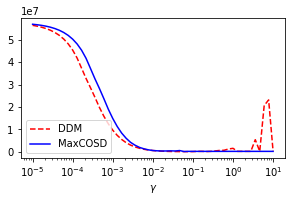

In [10]:
ddm_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1,len(list_gamma)+1)])
maxcosd_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])

plt.figure(figsize=(4.16,2.91))
plt.semilogx(list_gamma,ddm_mean_regret, color="red", label="DDM",linestyle="--")
plt.semilogx(list_gamma,maxcosd_mean_regret, color="blue", label="MaxCOSD")

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel(r"$\gamma$")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig("images/setting_3_gamma_logx.png", dpi=300)
plt.show()

#### $R_T$ as a function of $\gamma$ in loglog scale

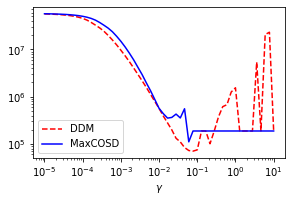

In [11]:
ddm_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1,len(list_gamma)+1)])
maxcosd_mean_regret = np.array([np.mean(cum_losses[:,gamma_index,-1]-cum_losses[:,0,-1]) for gamma_index in range(1*len(list_gamma)+1,2*len(list_gamma)+1)])

plt.figure(figsize=(4.16,2.91))
plt.loglog(list_gamma,ddm_mean_regret, color="red", label="DDM",linestyle="--")
plt.loglog(list_gamma,maxcosd_mean_regret, color="blue", label="MaxCOSD")

plt.xlabel(r"$\gamma$")
plt.legend(loc="lower left")

plt.tight_layout()
plt.savefig("images/setting_3_gamma_loglog.png", dpi=300)
plt.show()

#### $R_T/T$ as a function of $T$ in loglog scale

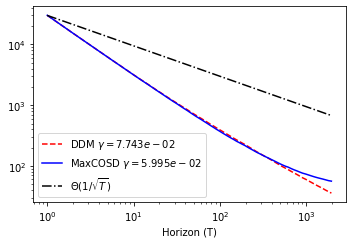

In [12]:
ddm_gamma_index_opt = np.argmin(np.mean(cum_losses[:,1:len(list_gamma)+1,-1],axis=0))+1
maxcosd_gamma_index_opt = np.argmin(np.mean(cum_losses[:,1*len(list_gamma)+1:2*len(list_gamma)+1,-1],axis=0))+1*len(list_gamma)+1
colors = {ddm_gamma_index_opt:"red", maxcosd_gamma_index_opt:"blue"}
linestyles = {ddm_gamma_index_opt:"--", maxcosd_gamma_index_opt:"-"}

plt.figure(figsize=(5,3.5))

for i in [ddm_gamma_index_opt, maxcosd_gamma_index_opt] :
    y = np.mean(cum_losses[:,i,:]-cum_losses[:,0,:],axis=0)
    plt.loglog(horizons, y/horizons,label=algs[i-1], color=colors[i], linestyle=linestyles[i])
plt.loglog(horizons,3*10**4/np.sqrt(horizons),"-.",color="k",label=r"$\Theta(1/\sqrt{T})$")

plt.xlabel("Horizon (T)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("images/setting_3_avgregret.png", dpi=300)
plt.show()